In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import tensorflow as tf
import random
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [2]:
SEED = 12
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

In [3]:
# import pandas as pd

# # 기존 데이터 경로
# data_path = r"C:\Users\Yoon\OneDrive\한양대학교\3-2\시계열\Assignment\Project\DB\Final_1h_No Missing.csv"

# # 새로 포함할 Feature 목록
# selected_features = ['inner_temperature', 'outside_temperature', 'wind_speed', 'timestamp', 'cooling_power']

# # 데이터 로드
# df = pd.read_csv(data_path)

# # 선택된 Feature만 포함
# df_selected = df[selected_features]

# # 새로운 파일 저장 경로
# output_path = r"C:\Users\Yoon\OneDrive\한양대학교\3-2\시계열\Assignment\Project\DB\Selected_Features.csv"
# df_selected.to_csv(output_path, index=False)

# output_path


In [4]:
data_path = r"C:\Users\Yoon\OneDrive\한양대학교\3-2\시계열\Assignment\Project\DB\Final_1h_Feature Engineering_No Missing.csv"


In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# 데이터 경로 설정
data_path = r"C:\Users\Yoon\OneDrive\한양대학교\3-2\시계열\Assignment\Project\DB\Final_1h_Feature Engineering_No Missing.csv"

def load_data(path=data_path):
    """Loads the dataset, drops 'timestamp', and splits into X (features) and Y (target)."""
    df = pd.read_csv(path)
    df = df.drop(columns=['timestamp'])  # 'timestamp' 제거
    X = df.drop(columns=['cooling_power'])  # 입력 변수
    Y = df[['cooling_power']]  # 타겟 변수
    return X, Y



def split_data(X, Y, train_fraq, test_len=108):
    """Splits input X and target Y into train, val, and test sets."""
    if test_len > len(X):
        raise ValueError("test_len cannot be greater than the total number of samples.")
    
    test_slice = len(X) - test_len

    X_test, Y_test = X[test_slice:], Y[test_slice:]
    X_train_val, Y_train_val = X[:test_slice], Y[:test_slice]

    train_size = int(len(X_train_val) * train_fraq)

    X_train, Y_train = X_train_val[:train_size], Y_train_val[:train_size]
    X_val, Y_val = X_train_val[train_size:], Y_train_val[train_size:]

    return (X_train, Y_train), (X_val, Y_val), (X_test, Y_test)


def min_max_scale(train_X, train_Y, val_X, val_Y, test_X, test_Y):
    """Applies MinMax Scaling using only the Train data for fitting."""
    mm_X = MinMaxScaler()
    mm_Y = MinMaxScaler()

    # Fit on Train data only
    train_X_scaled = mm_X.fit_transform(train_X)
    train_Y_scaled = mm_Y.fit_transform(train_Y)

    # Transform Validation and Test data
    val_X_scaled = mm_X.transform(val_X)
    val_Y_scaled = mm_Y.transform(val_Y)
    test_X_scaled = mm_X.transform(test_X)
    test_Y_scaled = mm_Y.transform(test_Y)

    return (train_X_scaled, train_Y_scaled), (val_X_scaled, val_Y_scaled), (test_X_scaled, test_Y_scaled), mm_X, mm_Y


def window_dataset(X, Y, n_steps, n_horizon, batch_size, shuffle_buffer, for_training=True):
    """
    Creates a windowed TensorFlow dataset.
    
    Parameters:
    - X: Input features
    - Y: Target values
    - n_steps: Number of timesteps in input
    - n_horizon: Prediction horizon
    - batch_size: Batch size for the dataset
    - shuffle_buffer: Buffer size for shuffling (applies only for training)
    - for_training: If True, applies shuffling for training data
    
    Returns:
    - A TensorFlow dataset object.
    """
    # Sliding window generation
    ds_X = tf.data.Dataset.from_tensor_slices(X)
    ds_Y = tf.data.Dataset.from_tensor_slices(Y)

    # Apply window
    ds_X = ds_X.window(n_steps, shift=n_horizon, drop_remainder=True).flat_map(lambda x: x.batch(n_steps))
    ds_Y = ds_Y.window(n_horizon, shift=n_horizon, drop_remainder=True).flat_map(lambda x: x.batch(n_horizon))

    # Combine inputs and targets
    ds = tf.data.Dataset.zip((ds_X, ds_Y))

    # Apply shuffle only for training data
    if for_training:
        ds = ds.shuffle(shuffle_buffer)

    # Batch and prefetch
    ds = ds.batch(batch_size).prefetch(1)
    return ds

In [6]:
def lstm_model(n_steps, n_horizon, n_features, lr):
    """Creates an LSTM model for predicting a single target variable."""

    # Clear any previous session
    tf.keras.backend.clear_session()

    # Build the model
    model = tf.keras.models.Sequential([
        # First LSTM Layer
        tf.keras.layers.LSTM(72, activation='relu', input_shape=(n_steps, n_features), return_sequences=True),
        
        # Second LSTM Layer
        tf.keras.layers.LSTM(48, activation='relu', return_sequences=False),
        
        # Dense Layers for Prediction
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.3),  # Dropout for regularization
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),  # Additional Dropout Layer
        
        # Output Layer (single value for n_horizon=1)
        tf.keras.layers.Dense(n_horizon)  # n_horizon=1 for single step prediction
    ], name='lstm')

    # Define loss and optimizer
    loss = tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    # Compile the model
    model.compile(loss=loss, optimizer=optimizer, metrics=['mae'])

    return model


In [7]:
X, Y = load_data()

# 데이터 분리
(train_X, train_Y), (val_X, val_Y), (test_X, test_Y) = split_data(X, Y, train_fraq=0.82, test_len=651)

# MinMax Scaling
(train_X_scaled, train_Y_scaled), (val_X_scaled, val_Y_scaled), (test_X_scaled, test_Y_scaled), mm_X, mm_Y = min_max_scale(
    train_X, train_Y, val_X, val_Y, test_X, test_Y
)

# TensorFlow Dataset 생성
train_ds = window_dataset(train_X_scaled, train_Y_scaled, n_steps=12, n_horizon=1, batch_size=32, shuffle_buffer=100, for_training=True)
val_ds = window_dataset(val_X_scaled, val_Y_scaled, n_steps=12, n_horizon=1, batch_size=32, shuffle_buffer=0, for_training=False)
test_ds = window_dataset(test_X_scaled, test_Y_scaled, n_steps=12, n_horizon=1, batch_size=32, shuffle_buffer=0, for_training=False)

In [8]:
# 스케일링 확인
print("Original train_Y range:", train_Y.min(), train_Y.max())
print("Scaled train_Y range:", train_Y_scaled.min(), train_Y_scaled.max())

# 복원 확인
train_Y_restored = mm_Y.inverse_transform(train_Y_scaled)
print("Restored train_Y range:", train_Y_restored.min(), train_Y_restored.max())


Original train_Y range: cooling_power    0.0
dtype: float64 cooling_power    43.81415
dtype: float64
Scaled train_Y range: 0.0 1.0
Restored train_Y range: 0.0 43.81415


In [9]:
print("Original train_X range:", train_X.min(), train_X.max())
print("Scaled train_X range:", train_X_scaled.min(), train_X_scaled.max())

# 복원 확인
train_X_restored = mm_X.inverse_transform(train_X_scaled)
print("Restored train_X range:", train_X_restored.min(), train_X_restored.max())


Original train_X range: Wind_Temperature_Interaction        9.09600
Wind_humidity_Interaction          19.44000
Temp_Humidity_Interaction        1393.49650
Temp_Difference                   -18.24500
Humidity_Difference               -40.06000
Rainfall_Humidity_Interaction       0.00000
server_power                       13.31851
outside_temperature                26.91000
outside_humidity                   37.15000
wind_speed                          0.30000
rainfall                            0.00000
inner_temperature                  16.24750
inner_humidity                     31.21667
dtype: float64 Wind_Temperature_Interaction      450.16000
Wind_humidity_Interaction         811.28700
Temp_Humidity_Interaction        2258.51460
Temp_Difference                     3.96250
Humidity_Difference                35.87667
Rainfall_Humidity_Interaction     409.64000
server_power                       15.18570
outside_temperature                38.78000
outside_humidity                   79

In [10]:
from tensorflow.keras.callbacks import EarlyStopping

# EarlyStopping 설정
early_stopping = EarlyStopping(
    monitor='val_loss',       # Validation Loss를 모니터링
    patience=30,              # 개선되지 않는 에포크 수 (5번 기다림)
    restore_best_weights=True # 가장 낮은 Validation Loss에서의 가중치 복원
)


In [11]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# # ReduceLROnPlateau 설정
lr_decay = ReduceLROnPlateau(
    monitor='val_loss',       # Validation Loss를 기준으로 Learning Rate 감소
    factor=0.8,               # Learning Rate를 50%로 줄임
    patience=15,               # 개선되지 않는 에포크 수 (5번 기다림)
    min_lr=1e-5               # Learning Rate의 하한값
)


In [12]:
model_checkpoint = ModelCheckpoint(
    filepath='best_lstm_all_features.keras',  # 저장 경로
    monitor='val_loss',       # 모니터링할 값
    save_best_only=True,      # Best 모델만 저장
    verbose=1
)

In [13]:
# LSTM 모델 생성
lstm = lstm_model(n_steps=12, n_horizon=1, n_features=train_X_scaled.shape[1], lr=3e-4)

# EarlyStopping 콜백
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

# Learning Rate Decay 콜백
lr_decay = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15, min_lr=1e-5)

# 모델 학습
history = lstm.fit(
    train_ds,
    validation_data=val_ds,
    epochs=300,
    callbacks=[early_stopping, lr_decay, model_checkpoint]  # 콜백 추가
)

# # 테스트 결과 출력
# lstm.evaluate(test_ds)


Epoch 1/300


c:\Users\Yoon\.conda\envs\gpt\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


     88/Unknown 4s 6ms/step - loss: 0.0696 - mae: 0.3165

c:\Users\Yoon\.conda\envs\gpt\Lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_loss improved from inf to 0.00113, saving model to best_lstm_all_features.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0663 - mae: 0.3053 - val_loss: 0.0011 - val_mae: 0.0373 - learning_rate: 3.0000e-04
Epoch 2/300
89/95 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0158 - mae: 0.1381
Epoch 2: val_loss did not improve from 0.00113
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0154 - mae: 0.1357 - val_loss: 0.0012 - val_mae: 0.0389 - learning_rate: 3.0000e-04
Epoch 3/300
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0147 - mae: 0.1307
Epoch 3: val_loss did not improve from 0.00113
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0146 - mae: 0.1300 - val_loss: 0.0012 - val_mae: 0.0372 - learning_rate: 3.0000e-04
Epoch 4/300
92/95 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0139 - mae: 0.1255
Epoch 4: val_loss improved from 0.00113 to 0.00076, saving model to best_lstm_all_features.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0136 - mae: 0.1240 - val_l

In [137]:
# import tensorflow as tf

# # GPU 사용 가능한지 확인
# gpus = tf.config.list_physical_devices('GPU')
# if gpus:
#     print(f"사용 가능한 GPU: {gpus}")
# else:
#     print("GPU를 찾을 수 없습니다. CPU를 사용합니다.")

In [138]:
# !pip uninstall tensorflow
# !pip install tensorflow


In [139]:
# !pip install tensorflow-gpu==2.6.0

In [140]:
# !nvcc --version  # CUDA Toolkit 버전 확인


In [14]:
# 테스트 데이터셋에서 예측 수행
y_pred_scaled = lstm.predict(test_ds)  # (samples, n_horizon) 형태

# y_pred를 (samples, 1)로 변환
y_pred = y_pred_scaled.reshape(-1, 1)  # 2차원으로 변환

# y_pred의 스케일 복원
y_pred = mm_Y.inverse_transform(y_pred)

# y_true를 TensorFlow Dataset에서 추출 및 스케일 복원
y_true_scaled = np.concatenate([y for x, y in test_ds], axis=0)  # (samples, n_horizon)
y_true = y_true_scaled.reshape(-1, 1)  # 2차원으로 변환
y_true = mm_Y.inverse_transform(y_true)


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [15]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# MAE (Mean Absolute Error)
mae = mean_absolute_error(y_true, y_pred)

# RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# MAPE (Mean Absolute Percentage Error)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# 성능 결과 출력
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")


MAE: 0.94
RMSE: 1.14
MAPE: 7.89%


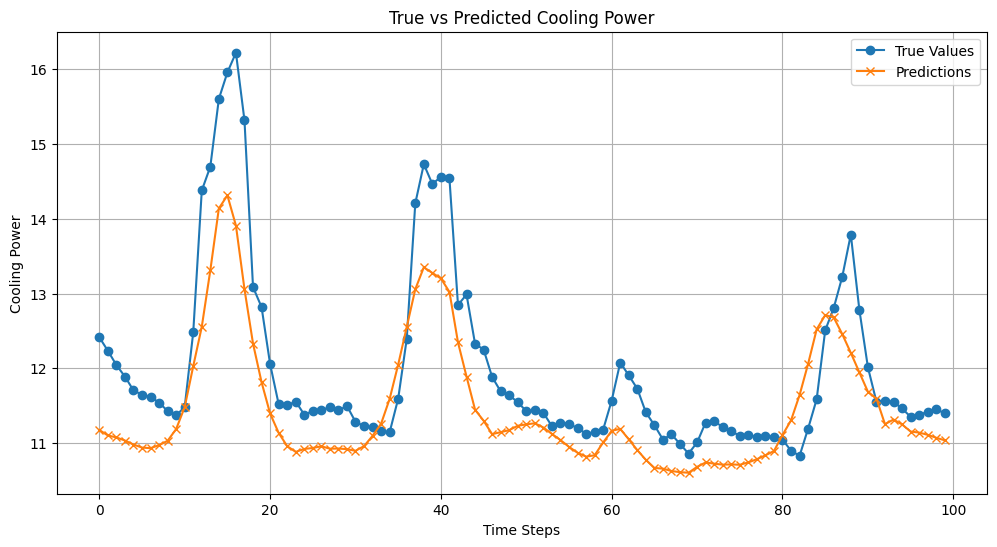

In [16]:
import matplotlib.pyplot as plt

# 샘플 수 선택 (테스트 데이터 일부만 시각화)

plt.figure(figsize=(12, 6))

plt.plot(y_true[:100], label="True Values", marker='o')
plt.plot(y_pred[:100], label="Predictions", marker='x')

plt.title("True vs Predicted Cooling Power")
plt.xlabel("Time Steps")
plt.ylabel("Cooling Power")
plt.legend()
plt.grid()
plt.show()


In [17]:
class PositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, max_len, embed_dim):
        super().__init__()
        self.pos_embedding = tf.keras.layers.Embedding(input_dim=max_len, output_dim=embed_dim)

    def call(self, inputs):
        positions = tf.range(start=0, limit=tf.shape(inputs)[1], delta=1)
        positions = self.pos_embedding(positions)
        return inputs + positions


In [18]:
model_checkpoint = ModelCheckpoint(
    filepath='best_transformer_all_features.keras',  # 저장 경로
    monitor='val_loss',       # 모니터링할 값
    save_best_only=True,      # Best 모델만 저장
    verbose=1
)

In [19]:
def transformer_model(n_steps, n_horizon, n_features, lr):
    """Creates an optimized Transformer model for time series forecasting."""

    # Clear any previous session
    tf.keras.backend.clear_session()

    # Input Layer
    inputs = tf.keras.layers.Input(shape=(n_steps, n_features))

    # Position Embedding
    position_embedding = PositionEmbedding(max_len=n_steps, embed_dim=n_features)(inputs)

    # Transformer Encoder
    transformer = tf.keras.layers.MultiHeadAttention(num_heads=4, key_dim=64)(position_embedding, position_embedding)
    transformer = tf.keras.layers.LayerNormalization(epsilon=1e-6)(transformer)
    transformer = tf.keras.layers.Dropout(0.1)(transformer)

    # Feed-Forward Network
    ff = tf.keras.layers.Dense(128, activation="relu")(transformer)
    ff = tf.keras.layers.Dropout(0.1)(ff)
    ff = tf.keras.layers.Dense(64, activation="relu")(ff)
    ff = tf.keras.layers.LayerNormalization(epsilon=1e-6)(ff)

    # Global Average Pooling
    pooled = tf.keras.layers.GlobalAveragePooling1D()(ff)

    # Output Layer
    outputs = tf.keras.layers.Dense(n_horizon)(pooled)

    # Build Model
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs, name="transformer")

    # Custom Learning Rate
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=lr,
        decay_steps=1000,
        decay_rate=0.96,
        staircase=True
    )

    # Compile Model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
                  loss="mse",
                  metrics=["mae"])

    return model


In [20]:
# EarlyStopping 콜백
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)


In [21]:
# LSTM 모델 생성
transformer = transformer_model(n_steps=12, n_horizon=1, n_features=train_X_scaled.shape[1], lr=3e-4)

# EarlyStopping 콜백
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

# Learning Rate Decay 콜백
lr_decay = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15, min_lr=1e-5)

# 모델 학습
history_transformer = transformer.fit(
    train_ds,
    validation_data=val_ds,
    epochs=300,  
    callbacks=[early_stopping, model_checkpoint]# 콜백 추가
)

Epoch 1/300
     94/Unknown 3s 6ms/step - loss: 0.0762 - mae: 0.2015

c:\Users\Yoon\.conda\envs\gpt\Lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_loss improved from inf to 0.00315, saving model to best_transformer_all_features.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0753 - mae: 0.2000 - val_loss: 0.0031 - val_mae: 0.0444
Epoch 2/300
91/95 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0169 - mae: 0.1041
Epoch 2: val_loss did not improve from 0.00315
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0168 - mae: 0.1036 - val_loss: 0.0045 - val_mae: 0.0565
Epoch 3/300
93/95 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0125 - mae: 0.0873
Epoch 3: val_loss did not improve from 0.00315
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0124 - mae: 0.0871 - val_loss: 0.0056 - val_mae: 0.0632
Epoch 4/300
87/95 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0125 - mae: 0.0885
Epoch 4: val_loss did not improve from 0.00315
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0123 - mae: 0.0875 - val_loss: 0.0052 - val_mae: 0.0590
Epoch 5/300
89/95 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0094 - mae: 0.0756
Epoch 5: val_loss

In [22]:
# 테스트 데이터셋에서 예측 수행
y_pred_scaled = transformer.predict(test_ds)  # (samples, n_horizon) 형태

# y_pred를 (samples, 1)로 변환
y_pred = y_pred_scaled.reshape(-1, 1)  # 2차원으로 변환

# y_pred의 스케일 복원
y_pred = mm_Y.inverse_transform(y_pred)

# y_true를 TensorFlow Dataset에서 추출 및 스케일 복원
y_true_scaled = np.concatenate([y for x, y in test_ds], axis=0)  # (samples, n_horizon)
y_true = y_true_scaled.reshape(-1, 1)  # 2차원으로 변환
y_true = mm_Y.inverse_transform(y_true)


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [23]:

# 성능 평가
from sklearn.metrics import mean_absolute_error, mean_squared_error

# MAE (Mean Absolute Error)
mae = mean_absolute_error(y_true, y_pred)

# RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# MAPE (Mean Absolute Percentage Error)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# 성능 결과 출력
print(f"Transformer Results")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")


Transformer Results
MAE: 0.79
RMSE: 0.99
MAPE: 6.37%


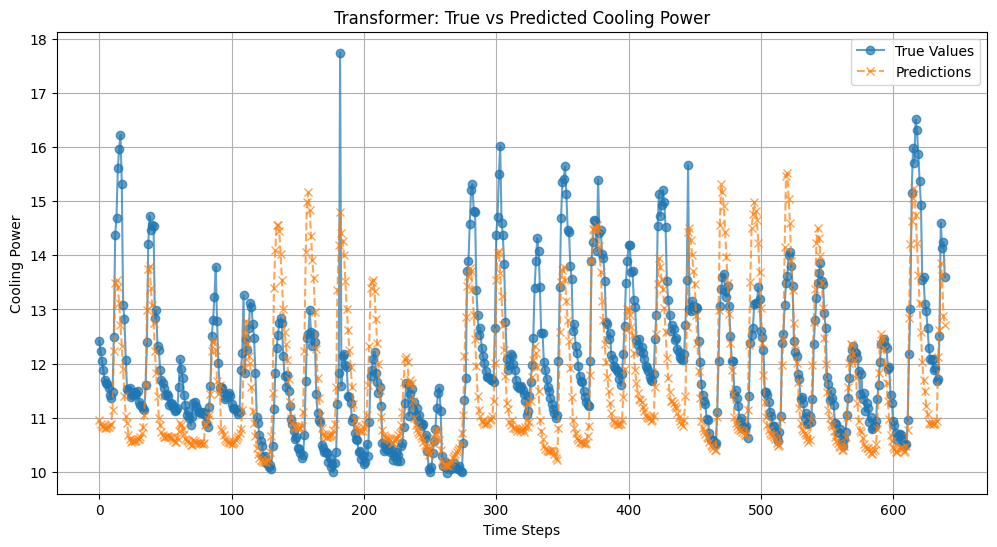

In [24]:

# 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# 샘플 수 선택 (테스트 데이터 일부만 시각화)
plt.plot(y_true, label="True Values", marker='o', linestyle='-', alpha=0.7)
plt.plot(y_pred, label="Predictions", marker='x', linestyle='--', alpha=0.7)

plt.title("Transformer: True vs Predicted Cooling Power")
plt.xlabel("Time Steps")
plt.ylabel("Cooling Power")
plt.legend()
plt.grid()
plt.show()
